In [37]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
import numpy as np
import json
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [41]:
def findme(a):
    for i in range(len(a)):
        if a[i] != 0:
            s = i
            break
    for i in range(len(a)-1, -1, -1):
        if a[i] != 0:
            f = i
            break
    return s, f

# Leitura do banco de dados

In [38]:
with open("dadosOeste.json", 'r') as j:
     data = json.loads(j.read())

In [39]:
data['3500105-cafe'].keys()

dict_keys(['area', 'yield', 'prop.landscape', 'patch.density', 'total.edge', 'edge.density', 'bio1', 'bio3', 'bio4', 'bio12', 'bio15'])

# Definição de parametros. 

In [296]:
# Label variavel a  prever
#Feature são as variáveis usadas para prever
#ts é numero de anos para serem considerados
#plantio é o plantio que queremos analisar

label = ['yield']
features = ['area', 'prop.landscape', 'patch.density', 'total.edge', 'edge.density', 'bio1', 'bio3', 'bio4', 'bio12', 'bio15']
ts = 4
plantio = 'melancia'

# Tratamento de dados

In [297]:
# TRATAMENTO DE DADOS
#1 Obtenção do dados BRUTOS

cafes = [i for i in list(data.keys()) if i.endswith(plantio)]
Xs, Ys = [], []
for crop in cafes:
    if all(v == 0 for v in data[crop][features[0]]):
        continue
    else:
        s,f = findme(data[crop][features[0]])
    X = []
    for i in range(len(features)):
        X += [data[crop][features[i]][s:f]]
    X = np.array(X).T
    Y = np.array([data[crop][label[0]][s:f]]).T
    Xs += [X]
    Ys += [Y]

#2 Sem 'nan's, por favor

Xsnew = []
Ysnew = []

for i in range(len(Xs)):
    x = Xs[i].copy()
    x[np.isnan(x)] = None
    ok = []
    for k in range(len(np.isnan(x))):
        if not np.isnan(x)[k].any():
            ok+= [k]
    Xsnew += [Xs[i][ok, :]]
    Ysnew += [Ys[i][ok]]

#3 Sem arrays vazioss também né, tá tirando

Xa = Xsnew.copy()
Ya = Ysnew.copy()
for i in range(len(Xs)-1, 0,-1):
    if len(Xs[i]) == 0:
        Xa.pop(i)
        Ya.pop(i)
Xs = Xa
Ys = Ya

#4 Precisam estar no formato (ts, features)

xs, ys = [], []
for k in range(len(Xs)):
    X = Xs[k]
    Y = Ys[k]
    x, y = [], []
    if len(X) < ts:
        continue
    elif len(X) == ts:
        x.append(X)
        y.append(Y[1])
        counter = 1
    else:
        counter = 0
        for i in range(ts, len(X)):
            x.append(X[i-ts:i])
            y.append(Y[i])
            counter +=1
    x, y = np.array(x).reshape(counter, ts, len(features)), np.array(y).reshape((counter, 1))
    if len(x) == 0:
        print(k)
    xs += [x]
    ys += [y]
Xf, Yf = xs[0], ys[0]
for i in range(1, len(xs)):
    Xf = np.append(Xf, xs[i], axis=0)
    Yf = np.append(Yf, ys[i], axis=0)

#5 E normalizados né?

Ym = (Yf - np.mean(Yf))/np.std(Yf)
Xm = Xf.copy()
for i in range(10):
    Xm[:,:,i] = (Xf[:,:,i] - np.mean(Xf[:,:,i]))/np.std(Xf[:,:,i])

#6 Obviamente separados, finalmente

X_train, X_test, Y_train, Y_test = train_test_split(
    Xm, Ym, test_size=0.2, random_state=42, shuffle=True)

# Modelo está a seguir.

In [298]:
RNN = keras.Sequential()
RNN.add(layers.LSTM(input_shape=(ts, 10), units= 200, return_sequences = True, time_major=True))
RNN.add(layers.LSTM(units= 200, return_sequences = False, time_major=False))
RNN.add(layers.Dropout(0.01))
RNN.add(layers.Dense(1))
RNN.compile(
    loss='mean_squared_error',
    optimizer="adam",
    metrics=[keras.metrics.RootMeanSquaredError()],)

In [299]:
RNN.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 4, 200)            168800    
_________________________________________________________________
lstm_27 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 201       
Total params: 489,801
Trainable params: 489,801
Non-trainable params: 0
_________________________________________________________________


In [300]:
RNN.fit(X_train, Y_train, epochs=40, validation_split=0.06)

Epoch 1/40
46/46 [==============================] - 4s 38ms/step - loss: 1.0118 - root_mean_squared_error: 0.9926 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 2/40
46/46 [==============================] - 1s 26ms/step - loss: 1.0402 - root_mean_squared_error: 0.9872 - val_loss: 0.2042 - val_root_mean_squared_error: 0.4519
Epoch 3/40
46/46 [==============================] - 1s 25ms/step - loss: 0.9243 - root_mean_squared_error: 0.9488 - val_loss: 0.1466 - val_root_mean_squared_error: 0.3829
Epoch 4/40
46/46 [==============================] - 1s 25ms/step - loss: 0.4371 - root_mean_squared_error: 0.6461 - val_loss: 0.1464 - val_root_mean_squared_error: 0.3827
Epoch 5/40
46/46 [==============================] - 1s 25ms/step - loss: 0.4950 - root_mean_squared_error: 0.6979 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2037
Epoch 6/40
46/46 [==============================] - 1s 25ms/step - loss: 0.6620 - root_mean_squared_error: 0.8080 - val_loss: 0.0676 - val_root_m

In [303]:
predics = RNN.predict(X_test)
Ynz = np.where(Y_test != 0)[0]
print('Precisão do modelo:',np.mean(predics/Y_test)*100)

Precisão do modelo: 96.48756142977113


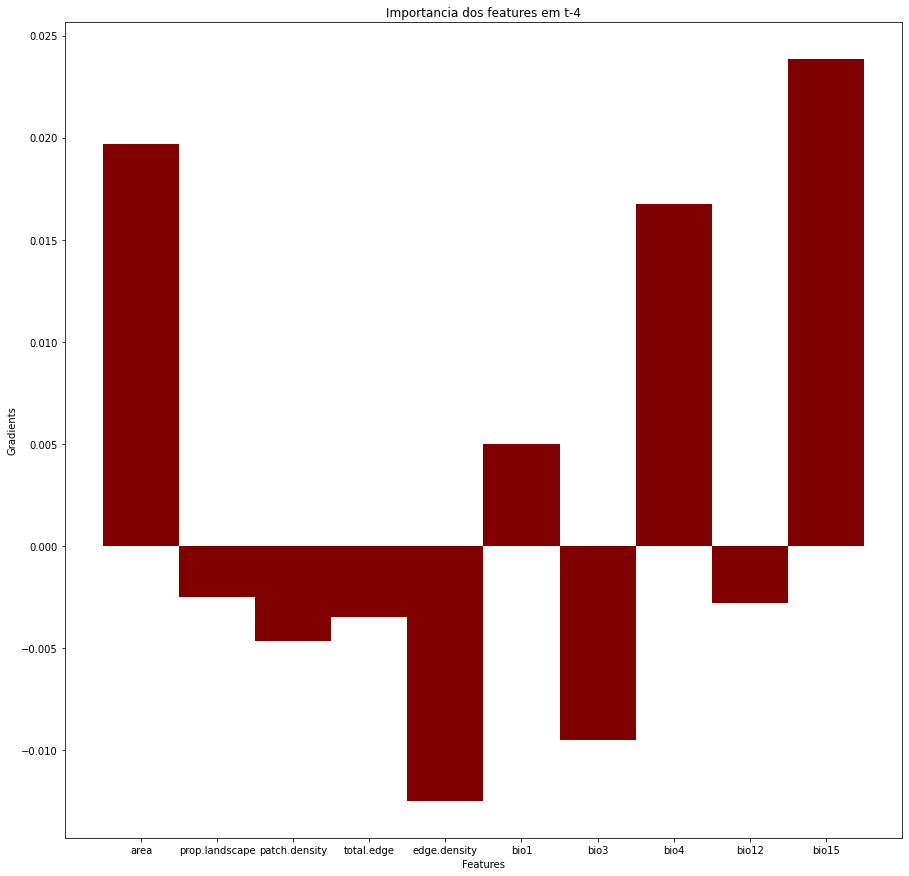

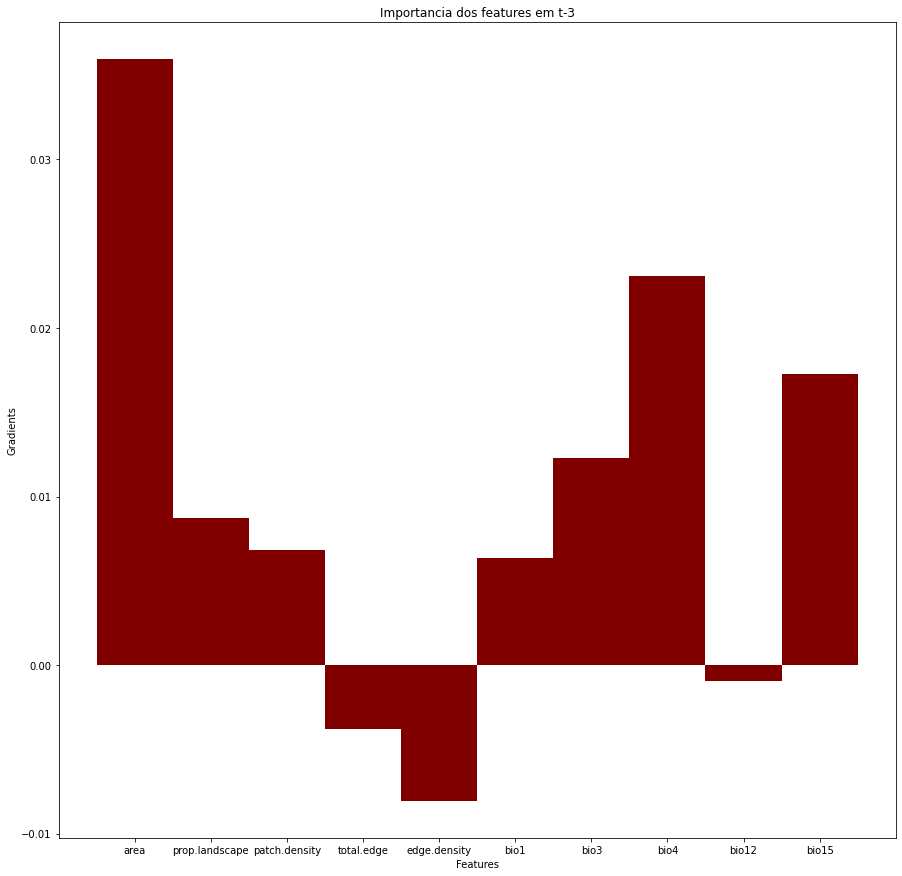

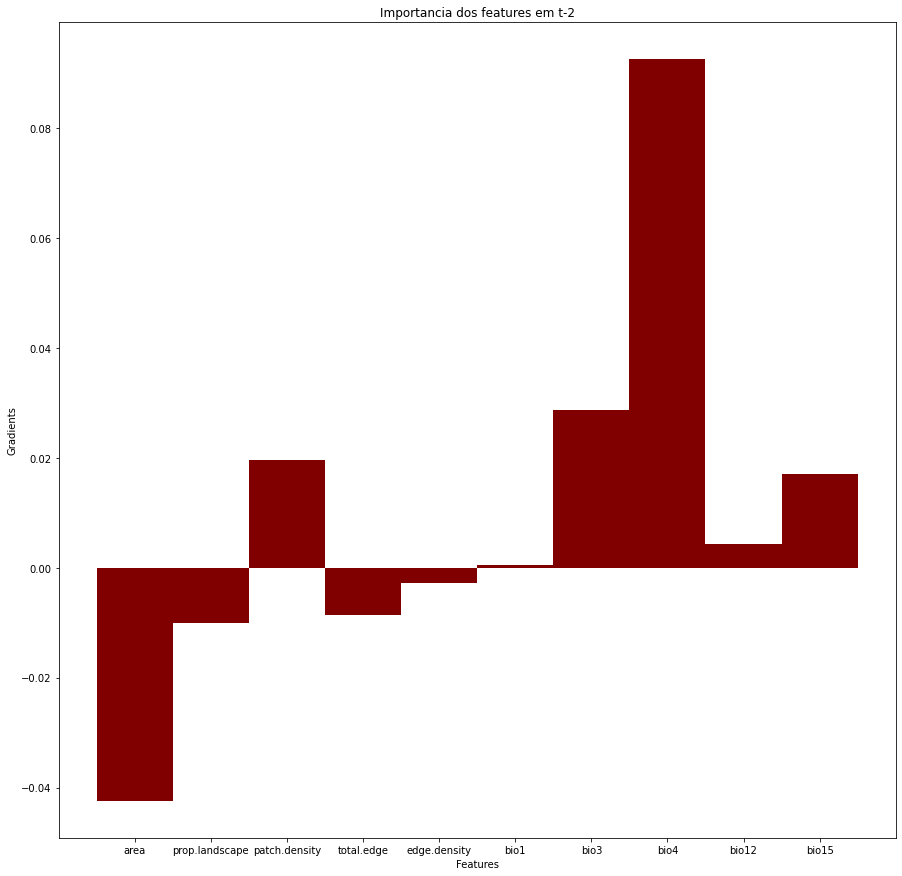

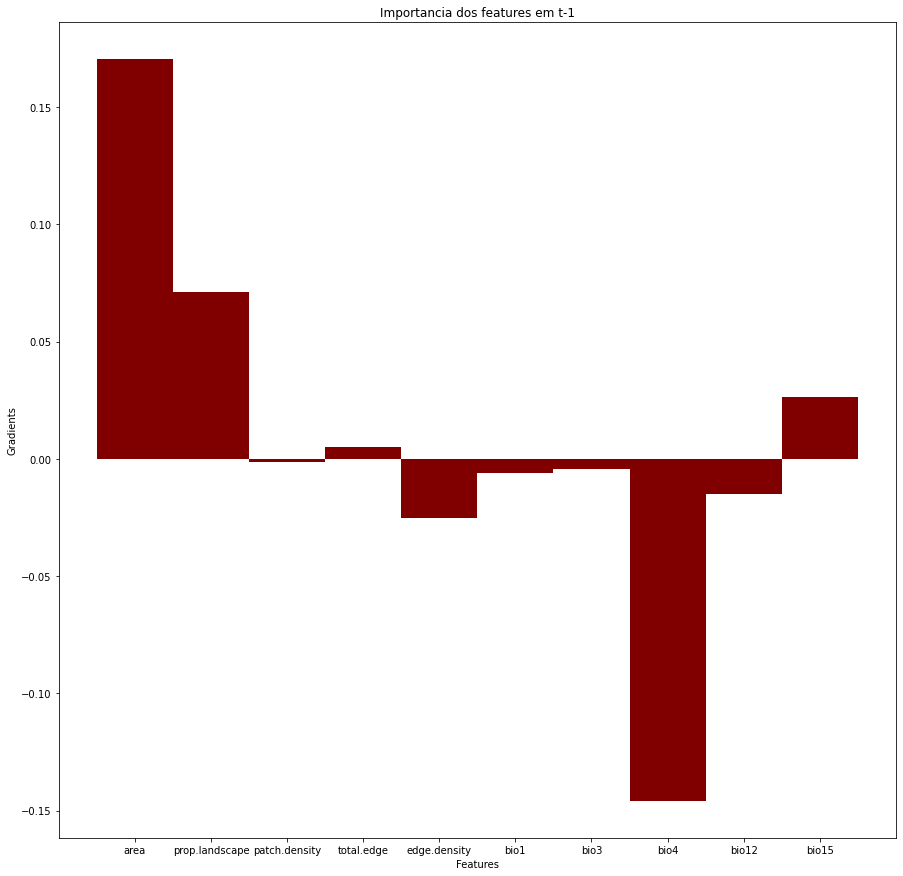

In [302]:
# Analise de gradiente do modelo
# Basicamente, aqui diz como cada variável influência na predição final, com quantidade e sinal
# E cada gráfico representa o peso da variável naquele ano.

sq = tf.Variable(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    predics = RNN(sq)
grads = tape.gradient(predics, sq)
grads = tf.reduce_mean(grads, axis=0).numpy()

for i in range(grads.shape[0]):
    fig = plt.figure(figsize=(15,15))
    plt.bar(features, grads[i], color ='maroon', width = 1)
    plt.xlabel("Features")
    plt.ylabel("Gradients")
    plt.title("Importancia dos features em t-{}".format(ts-i))
    plt.show()

In [46]:
np.sum(grads[4])

-0.051554978